## Data Prep

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns
pd.show_versions()
import sys
import graphviz
sys.executable
#import graphviz


INSTALLED VERSIONS
------------------
commit: None
python: 3.6.5.final.0
python-bits: 32
OS: Windows
OS-release: 10
machine: AMD64
processor: Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8
LOCALE: None.None

pandas: 0.24.0
pytest: None
pip: 18.1
setuptools: 39.0.1
Cython: None
numpy: 1.14.3
scipy: 1.1.0
pyarrow: None
xarray: None
IPython: 6.4.0
sphinx: None
patsy: 0.5.1
dateutil: 2.7.3
pytz: 2018.4
blosc: None
bottleneck: None
tables: None
numexpr: None
feather: None
matplotlib: 2.2.2
openpyxl: None
xlrd: None
xlwt: None
xlsxwriter: None
lxml.etree: 4.2.5
bs4: None
html5lib: 1.0.1
sqlalchemy: None
pymysql: None
psycopg2: None
jinja2: 2.10
s3fs: None
fastparquet: None
pandas_gbq: None
pandas_datareader: None
gcsfs: None


'c:\\users\\rapp\\appdata\\local\\programs\\python\\python36-32\\python.exe'

In [2]:
data = [pd.read_csv('asos_snotel_UA_12hr_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_snotel_UA_df = pd.concat(data)
#asos_snotel_UA_df['LXV_WindSpeed_m/s']

#asos_snotel_UA_df.rename(columns={'LXV_WindSpeed_m/s': 'LXV_WindSpeed_mps'}, inplace=True)

asos_snotel_UA_df.astype('float16')
pd.set_option('display.expand_frame_repr', True)


print(asos_snotel_UA_df.keys())




#delete empty columns as they mess up loops
#del asos_snotel_UA_df['CMtn_6hr_Precipitation_mm']            #empty column


Index(['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
       'LXV_Temperature_degC', 'LXV_Dewpoint_degC',
       ...
       'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc',
       'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts',
       'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc',
       'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts'],
      dtype='object', length=163)


It is important to keep in mind that 'CMtnSNTL_12hr_SNWD_in contains snow depth info taken at the start of the respective 12hr period timestamp.  The snowfall calculated also gives the snowfall that fell in the 12hrs after the timestamp.  The model will utilize hourly meteorological measurements at exactly 00:00 and 12:00 hours to predict the amount of snow which will fall in the next 12 hour period.  For example, the 00:00 meteorological measurements will be used to predict the snow which fell between 00:00 and 12:00.

# Decision Tree with Surface and Upper Air Features

### Now identify variables which have good data capture

In [3]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_drct', 'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_drct', 'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_drct', 'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_drct', 'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_drct', 'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_drct', 'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_drct', 'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts']

good_vars_sfcua = []
bad_vars_sfcua = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df['2009':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df['2009':'2017'][var])
    total_poss = len(asos_snotel_UA_df['2009':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df['2009':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    total_avail =len(asos_snotel_UA_df['2009':'2017'][idx])
    if total_avail/total_poss >= 0.67: 
        good_vars_sfcua.append(var)
    else:
        bad_vars_sfcua.append(var)
        
print('Variables with >= 67% data match to snowfall: ')
print(good_vars_sfcua )
print('Variables with < 67% data match to snowfall: ')
print(bad_vars_sfcua )

Variables with >= 67% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_

### Set up test data

In [4]:
#asos_snotel_UA_df['LXV_12hr_delta_Pressure_hp'] = asos_snotel_UA_df['LXV_Pressure_hp']-asos_snotel_UA_df['LXV_Pressure_hp'].shift(+12)
#print(asos_snotel_UA_df['LXV_12hr_delta_Pressure_hp'].describe())
all_yrs = (asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index <= '12-31-2017')
test_yrs = ((asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index <= '12-31-2006')) | ((asos_snotel_UA_df.index >= '01-01-2017') & (asos_snotel_UA_df.index <= '12-31-2017'))
train_yrs = (asos_snotel_UA_df.index >= '01-01-2007') & (asos_snotel_UA_df.index <= '12-31-2016')

print(asos_snotel_UA_df[all_yrs]['CMtnSNTL_Temp_degC'].describe())
print(asos_snotel_UA_df[test_yrs]['CMtnSNTL_Temp_degC'].describe())
print(asos_snotel_UA_df[train_yrs]['CMtnSNTL_Temp_degC'].describe())

count    8710.000000
mean       -0.001883
std         8.559429
min       -30.600000
25%        -6.270000
50%         0.000000
75%         7.300000
max        19.100000
Name: CMtnSNTL_Temp_degC, dtype: float64
count    1405.000000
mean        0.694235
std         8.115662
min       -28.100000
25%        -4.800000
50%         0.600000
75%         7.500000
max        18.300000
Name: CMtnSNTL_Temp_degC, dtype: float64
count    7303.000000
mean       -0.132398
std         8.634992
min       -30.600000
25%        -6.470000
50%        -0.100000
75%         7.250000
max        19.100000
Name: CMtnSNTL_Temp_degC, dtype: float64


In [5]:
Xtest = []
Xtest_feat =[]
Ytest = []
Ytest_actsnf = []
idx_test = []

idx_test = np.isfinite(asos_snotel_UA_df[test_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'])
for v in good_vars_sfcua:
    idx_test = idx_test & np.isfinite(asos_snotel_UA_df[test_yrs][v])    
    
Ytest = round(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][test_yrs][idx_test],0)
Ytest_actsnf  = Ytest.tolist()

gv = pd.DataFrame()
#gv_asos_snotel_UA_df = asos_snotel_UA_df.copy
#gv_asos_snotel_UA_df = asos_snotel_UA_df['2009':'2017'][['LXV_Temperature_degC', 'LXV_WindSpeed_mps', 'LXV_Dewpoint_degC']][loop_idx]
Xtest = asos_snotel_UA_df[test_yrs][good_vars_sfcua][idx_test].apply(lambda x: x.tolist(), axis=1)
#testtrain2 = testlist.apply(lambda x: testtrain2.append(x))
Xtest_feat = Xtest.tolist()
print(Xtest_feat[0:5], Ytest_actsnf[0:5])


[[-3.2, -7.0, -8.0, 340.0, 5.1, -4.4, -7.2, 993.4, 2.6, 70.0, -5.2, 11750.0, -45.1, -51.1, 265.0, 35.0, 10260.0, -44.1, -49.1, 265.0, 24.0, 9050.0, -45.1, -49.5, 250.0, 25.0, 7100.0, -33.9, -37.1, 245.0, 4.0, 5490.0, -21.3, -23.4, 270.0, 24.0, 2921.0, -4.7, -5.4, 260.0, 36.0, 1364.0, -1557.0, -4126.0, -5736.0, -7686.0, -8896.0, -10386.0, -2569.0, 16.6, 18.0, -10.0, 12.0, -4179.0, 29.2, 31.7, 15.0, 32.0, -6129.0, 40.4, 44.1, 10.0, 11.0, -7339.0, 39.4, 43.7, -5.0, 12.0, -8829.0, 40.4, 45.7, -5.0, 1.0, -1610.0, 12.6, 13.7, 25.0, 20.0, -3560.0, 23.8, 26.1, 20.0, -1.0, -4770.0, 22.8, 25.7, 5.0, 0.0, -6260.0, 23.8, 27.7, 5.0, -11.0, -1950.0, 11.2, 12.4, -5.0, -21.0, -3160.0, 10.2, 12.0, -20.0, -20.0, -4650.0, 11.2, 14.0, -20.0, -31.0, -1210.0, -1.0, -0.4, -15.0, 1.0, -2700.0, 0.0, 1.6, -15.0, -10.0, -1490.0, 1.0, 2.0, 0.0, -11.0], [-8.2, -9.0, -12.0, 290.0, 7.7, -7.0, -9.0, 1004.3, 1.5, 180.0, -5.4, 11730.0, -53.5, -73.5, 285.0, 60.0, 10280.0, -49.5, -69.5, 290.0, 62.0, 9080.0, -44.7, -63.7,

### Set up training data with 2009-200

In [6]:
Xtrain = []
Xtrain_feat =[]
Ytrain = []
Ytrain_actsnf = []
idx_test = []

idx_train = np.isfinite(asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'])
for v in good_vars_sfcua:
    idx_train = idx_train & np.isfinite(asos_snotel_UA_df[train_yrs][v])    
    
Ytrain = round(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][train_yrs][idx_train],0)
Ytrain_actsnf = Ytrain.tolist()


gv = pd.DataFrame()
#gv_asos_snotel_UA_df = asos_snotel_UA_df.copy
#gv_asos_snotel_UA_df = asos_snotel_UA_df[train_yrs][['LXV_Temperature_degC', 'LXV_WindSpeed_mps', 'LXV_Dewpoint_degC']][loop_idx]
Xtrain = asos_snotel_UA_df[train_yrs][good_vars_sfcua][idx_train].apply(lambda x: x.tolist(), axis=1)
#testtrain2 = testlist.apply(lambda x: testtrain2.append(x))
Xtrain_feat = Xtrain.tolist()
    
print(Xtrain_feat[0:5], Ytrain_actsnf[0:5])

    

[[-0.6, -5.0, -10.0, 250.0, 9.3, -0.6, -8.9, 998.6, 1.5, 70.0, -6.0, 11880.0, -48.9, -62.9, 280.0, 129.0, 10400.0, -45.1, -58.1, 280.0, 149.0, 9170.0, -39.3, -52.3, 270.0, 140.0, 7180.0, -32.3, -36.3, 275.0, 80.0, 5560.0, -19.7, -22.5, 260.0, 54.0, 2969.0, 0.4, -9.6, 240.0, 33.0, 1384.0, -1585.0, -4176.0, -5796.0, -7786.0, -9016.0, -10496.0, -2591.0, 20.1, 12.9, -20.0, -21.0, -4211.0, 32.7, 26.7, -35.0, -47.0, -6201.0, 39.7, 42.7, -30.0, -107.0, -7431.0, 45.5, 48.5, -40.0, -116.0, -8911.0, 49.3, 53.3, -40.0, -96.0, -1620.0, 12.6, 13.8, -15.0, -26.0, -3610.0, 19.6, 29.8, -10.0, -86.0, -4840.0, 25.4, 35.6, -20.0, -95.0, -6320.0, 29.2, 40.4, -20.0, -75.0, -1990.0, 7.0, 16.0, 5.0, -60.0, -3220.0, 12.8, 21.8, -5.0, -69.0, -4700.0, 16.6, 26.6, -5.0, -49.0, -1230.0, 5.8, 5.8, -10.0, -9.0, -2710.0, 9.6, 10.6, -10.0, 11.0, -1480.0, 3.8, 4.8, 0.0, 20.0], [-3.2, -7.0, -13.0, 260.0, 6.2, -2.2, -11.1, 1001.1, 3.6, 200.0, 0.5, 11640.0, -51.9, -62.9, 255.0, 39.0, 10210.0, -56.5, -66.5, 245.0, 31.0, 9

### Run model 

DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
6.594787143223441
43


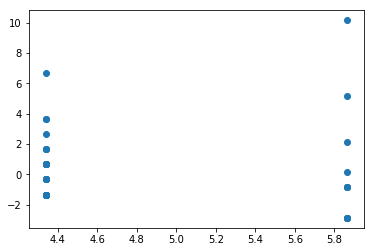

In [32]:
clf =[]
Y_predsnf = []

from sklearn import tree
clf = tree.DecisionTreeRegressor(max_depth=1)
clf = clf.fit(Xtrain_feat, Ytrain_actsnf)

print(clf)

# Predict test set labels
Y_predsnf = clf.predict(Xtest_feat)
# Evaluate test-set accuracy


from sklearn.metrics import mean_squared_error
print(mean_squared_error(Ytest_actsnf, Y_predsnf))
#print(accuracy_score(Ytest_actsnf, Y_predsnf))
#plt.plot(Ytestlist-y_pred) 


plt.scatter(Y_predsnf, Ytest_actsnf-Y_predsnf)
print(len(Y_predsnf))


['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_he

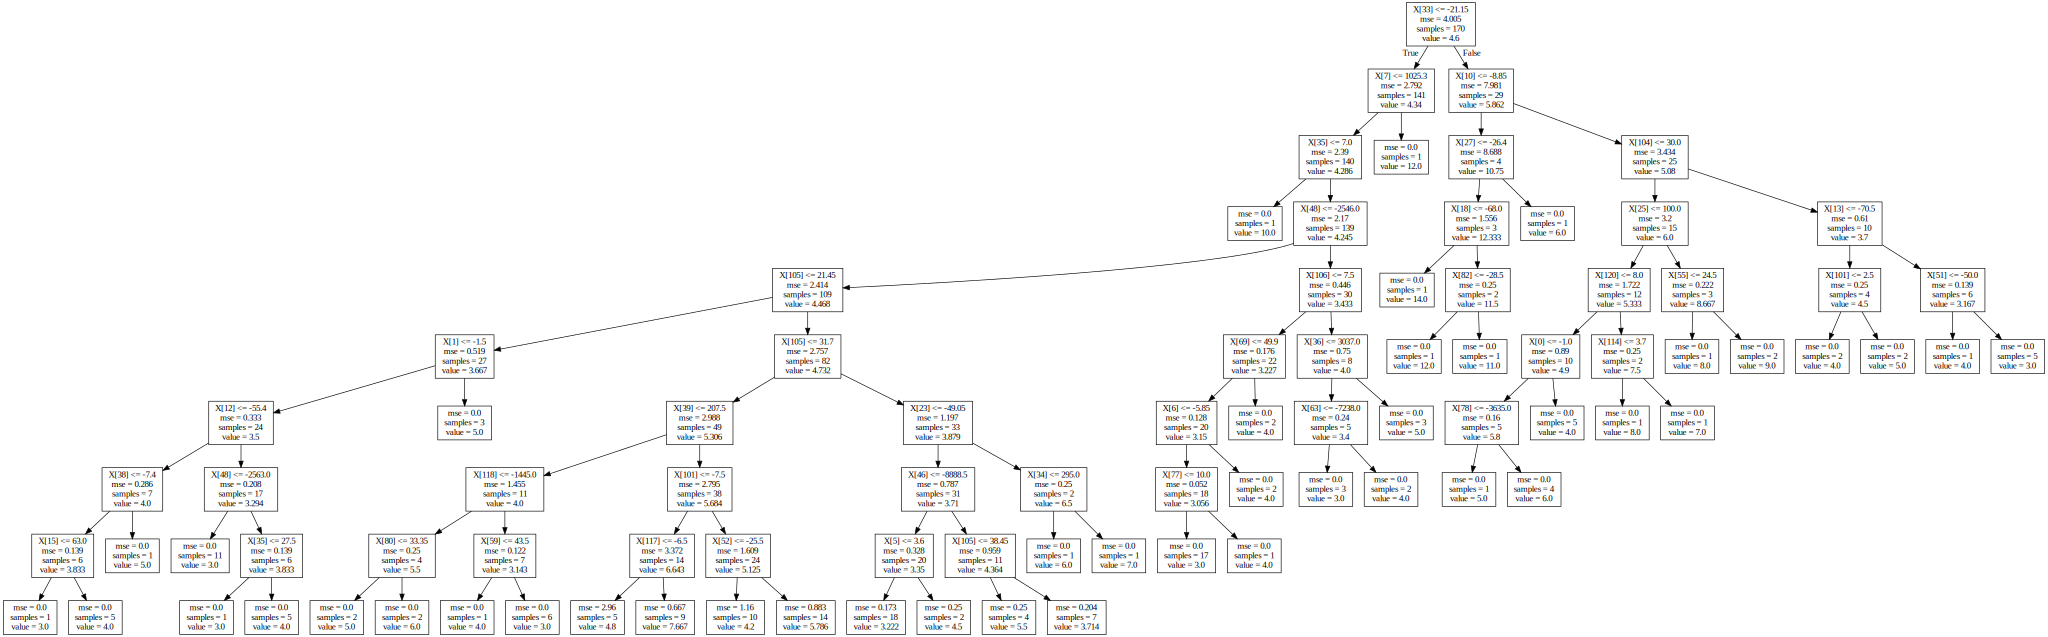

In [22]:

import graphviz 

dot_data = tree.export_graphviz(clf, out_file=None, feature_names=good_vars_sfcua, filled = True,special_characters = True, class_names = True, max_depth = 1) 
graph = graphviz.Source(dot_data) 


print(good_vars_sfcua)
#graph.render() 
#dot_data = tree.export_graphviz(clf, out_file=None, 
#                      feature_names=iris.feature_names,  
#                      class_names=iris.target_names,  
#                      filled=True, rounded=True,  
#                      special_characters=True)

dot_data = tree.export_graphviz(clf)

tree.export_graphviz(clf)
graph = graphviz.Source(dot_data)  
graph 



In [23]:
from tabulate import tabulate
num = np.arange(0,len(good_vars_sfcua),1)
tbl = list(zip(num, good_vars_sfcua))
print(tabulate(tbl, headers=["Num","Max"]))

  Num  Max
-----  --------------------------
    0  CMtnSNTL_Temp_degC
    1  CMtn_Temperature_degC
    2  CMtn_Dewpoint_degC
    3  CMtn_WindDirection_deg
    4  CMtn_WindSpeed_mps
    5  LXV_Temperature_degC
    6  LXV_Dewpoint_degC
    7  LXV_Pressure_hp
    8  LXV_WindSpeed_mps
    9  LXV_WindDirection_deg
   10  LXV_12hr_delta_Pressure_hp
   11  KGJT_200mb_height_m
   12  KGJT_200mb_tmpc
   13  KGJT_200mb_dwpc
   14  KGJT_200mb_drct
   15  KGJT_200mb_speed_kts
   16  KGJT_250mb_height_m
   17  KGJT_250mb_tmpc
   18  KGJT_250mb_dwpc
   19  KGJT_250mb_drct
   20  KGJT_250mb_speed_kts
   21  KGJT_300mb_height_m
   22  KGJT_300mb_tmpc
   23  KGJT_300mb_dwpc
   24  KGJT_300mb_drct
   25  KGJT_300mb_speed_kts
   26  KGJT_400mb_height_m
   27  KGJT_400mb_tmpc
   28  KGJT_400mb_dwpc
   29  KGJT_400mb_drct
   30  KGJT_400mb_speed_kts
   31  KGJT_500mb_height_m
   32  KGJT_500mb_tmpc
   33  KGJT_500mb_dwpc
   34  KGJT_500mb_drct
   35  KGJT_500mb_speed_kts
   36  KGJT_700mb_height_m
   37  

Try max depth 10

DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
6.594787143223441
43


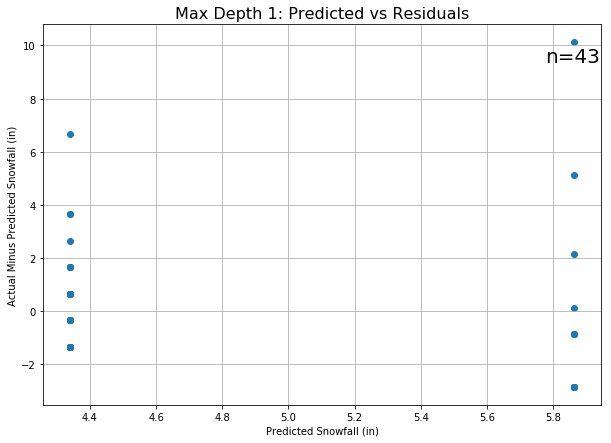

In [56]:
clf =[]
Y_predsnf = []

from sklearn import tree
clf = tree.DecisionTreeRegressor(max_depth=1)
clf = clf.fit(Xtrain_feat, Ytrain_actsnf)

print(clf)

# Predict test set labels
Y_predsnf = clf.predict(Xtest_feat)
# Evaluate test-set accuracy

from sklearn.metrics import mean_squared_error
print(mean_squared_error(Ytest_actsnf, Y_predsnf))
#plt.plot(Ytestlist-y_pred) 

fig = plt.figure(figsize=(10,7))
plt.xlabel('Predicted Snowfall (in)')
plt.ylabel('Actual Minus Predicted Snowfall (in)')

plt.scatter(Y_predsnf, Ytest_actsnf-Y_predsnf)
plt.grid(True)



plt.annotate('n=' + str(len(Y_predsnf)), xy=(0.9, 0.9), xycoords='axes fraction', fontsize=20)

print(len(Y_predsnf))

plt.title('Max Depth 1: Predicted vs Residuals', fontsize = 16)

plt.savefig('C:/Users/RAPP/Documents/Capstone/MS_CS_report/figs/TREE_pred_vs_residuals_UASFC.png',bbox_inches='tight')

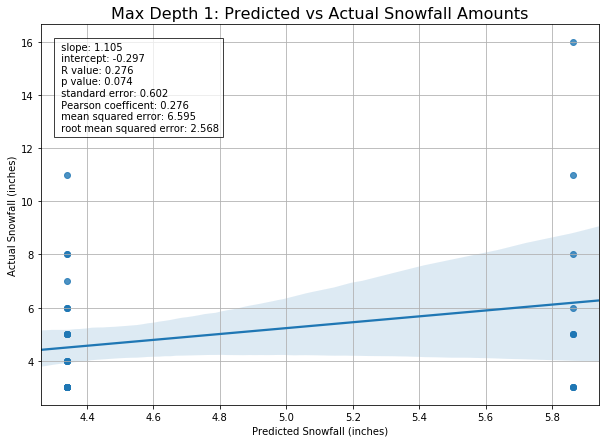

In [46]:
from scipy.stats import pearsonr, linregress
from sklearn.metrics import mean_squared_error


fig = plt.figure(figsize=(10,7))

## Do linear regression and calculate slope, intercept, r, p, std err
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(Y_predsnf, Ytest_actsnf)
#Calculate mse and rmse
mse = mean_squared_error(Y_predsnf, Ytest_actsnf)
rmse = np.sqrt(mse)
pearson1, pv = pearsonr(Y_predsnf, Ytest_actsnf)

#plot and annotate
sns.regplot(Y_predsnf, Ytest_actsnf)
bbox_props=dict(facecolor='red', alpha=0.75, fc = 'white')
plt.annotate(' slope: ' + str(round(slope1,3)) +
                 '\n intercept: ' + str(round(intercept1,3)) + 
                 '\n R value: ' + str(round(r_value1,3)) +  
                 '\n p value: ' + str(round(p_value1,3)) + 
                 '\n standard error: ' + str(round(std_err1,3)) +
                 '\n Pearson coefficent: ' + str(round(pearson1,3)) +
                 '\n mean squared error: ' + str(round(mse,3)) +
                 '\n root mean squared error: ' + str(round(rmse,3)), \
                 xy=(0.03, 0.72), xycoords='axes fraction', fontsize=10, bbox = bbox_props)

plt.xlabel('Predicted Snowfall (inches)')
plt.ylabel('Actual Snowfall (inches)')
#plt.xlim([3,6])
#plt.ylim([-3,16])
plt.grid(True)
plt.title('Max Depth 1: Predicted vs Actual Snowfall Amounts', fontsize = 16)
plt.savefig('C:/Users/RAPP/Documents/Capstone/MS_CS_report/figs/TREE_pred_vs_act_UASFC.png',bbox_inches='tight')

Try multpile max depths

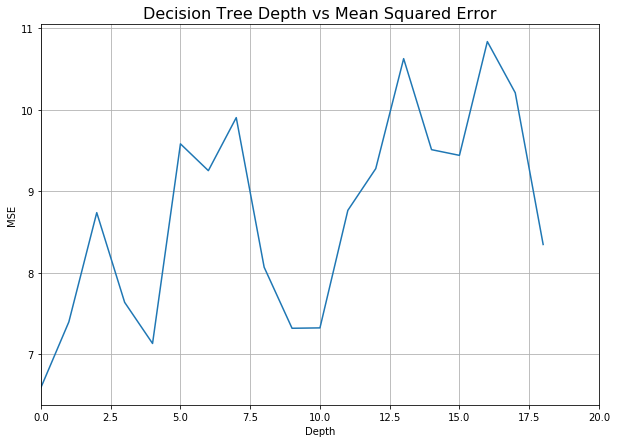

In [48]:
from sklearn import tree
from sklearn.metrics import accuracy_score
mse = []

for i in range(1,20):
  clf = []
  clf = tree.DecisionTreeRegressor(max_depth=i)
  clf = clf.fit(Xtrain_feat, Ytrain_actsnf)

#print(clf)

# Predict test set labels
  Y_predsnf = clf.predict(Xtest_feat)
# Evaluate test-set accuracy


  mse.append(mean_squared_error(Ytest_actsnf, Y_predsnf))
#plt.plot(Ytestlist-y_pred) 


fig = plt.figure(figsize=(10,7))
plt.plot(mse)
plt.title('Decision Tree Depth vs Mean Squared Error', fontsize = 16)

plt.xlabel('Depth')
plt.ylabel('MSE')
plt.xlim(0,20)
plt.grid(True)


plt.savefig('C:/Users/RAPP/Documents/Capstone/MS_CS_report/figs/TREE_depth_vs_mse_UASFC.png',bbox_inches='tight')

277


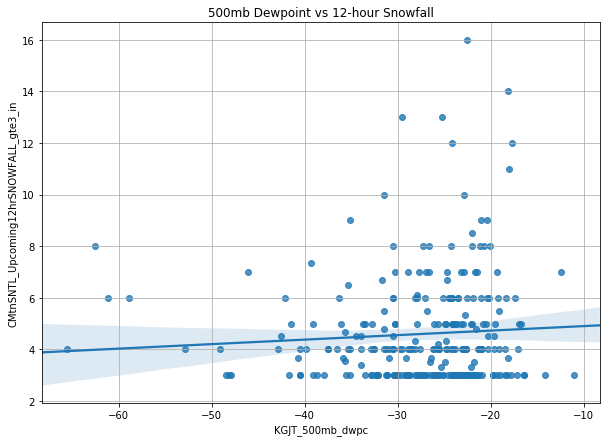

In [52]:
idx_train = np.isfinite(asos_snotel_UA_df[train_yrs]['KGJT_500mb_dwpc']) & np.isfinite(asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'])
print(len(asos_snotel_UA_df[train_yrs]['KGJT_500mb_dwpc'][idx_train]))


fig = plt.figure(figsize=(10,7))
sns.regplot(asos_snotel_UA_df[train_yrs]['KGJT_500mb_dwpc'][idx_train], asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][idx_train])
plt.grid(True)

plt.title('Traiing Data: 500mb Dewpoint vs 12-hour Snowfall')
plt.savefig('C:/Users/RAPP/Documents/Capstone/MS_CS_report/figs/Training_TREE_500mbDP_vs_Snowfall.png',bbox_inches='tight')

55


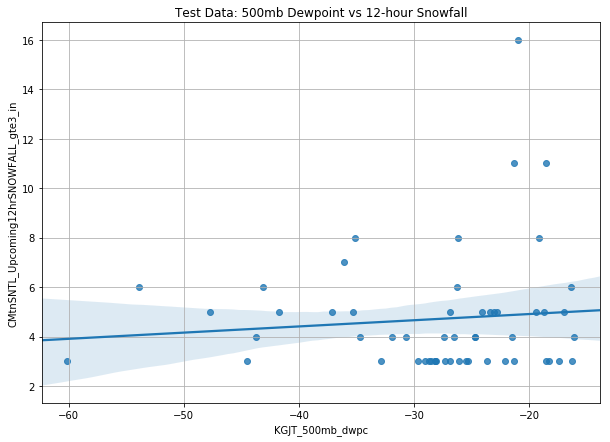

In [54]:
idx_test = np.isfinite(asos_snotel_UA_df[test_yrs]['KGJT_500mb_dwpc']) & np.isfinite(asos_snotel_UA_df[test_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'])
print(len(asos_snotel_UA_df[test_yrs]['KGJT_500mb_dwpc'][idx_test]))

fig = plt.figure(figsize=(10,7))
sns.regplot(asos_snotel_UA_df[test_yrs]['KGJT_500mb_dwpc'][idx_test], asos_snotel_UA_df[test_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][idx_test])
plt.grid(True)

plt.title('Test Data: 500mb Dewpoint vs 12-hour Snowfall')
plt.savefig('C:/Users/RAPP/Documents/Capstone/MS_CS_report/figs/TestData_TREE_500mbDP_vs_Snowfall.png',bbox_inches='tight')